In [1]:
import transformer_lens as tl
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from functools import partial
import wandb

In [3]:
base_name = "gpt2-small"
model = tl.HookedTransformer.from_pretrained(base_name)
print(model)


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

C:\Users\dylan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\dylan\.cache\huggingface\hub\models--gpt2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer
HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (ln1): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_ou

In [27]:
def encode(text):
    return model.to_tokens(text)
def decode(tensor):
    assert tensor.dim() <= 2
    return model.to_string(tensor)

sample_text = "Hello, my name is"
# print(encode(sample_text).shape)
logits : Tensor = model(encode(sample_text))[0]
predictions = sample_text + decode(logits.argmax(dim=-1))
print(logits)

tensor([[ 7.5261, 11.1214,  7.8919,  ..., -3.1299, -3.3873,  8.5934],
        [12.6877,  5.6732,  1.4202,  ..., -0.1857, -0.5829,  5.4394],
        [ 7.0629,  2.4974,  1.9990,  ...,  0.3997, -1.0289,  6.9055],
        [ 6.0858,  4.1763,  3.4770,  ...,  1.8539, -2.2758,  2.3654],
        [ 9.2422,  7.4983,  2.9180,  ..., -0.8511, -5.5091,  4.2596],
        [ 5.5007,  4.7898,  1.2857,  ..., -2.5194, -2.5051,  4.6008]],
       grad_fn=<SelectBackward0>)


In [61]:
import random
from typing import *
from tqdm import tqdm
NEAR_ZERO = 1e-5
default_loss = nn.CrossEntropyLoss()
def det_loss_fn_1(logits: Tensor, lb = -1, ub = 1, sparsity = 0.5) -> Tensor:
    """
    Randomizes loss for each token sequence.
    """
    input_tokens = torch.multinomial(logits.softmax(dim=-1), 1).squeeze(1)
    input_text = decode(input_tokens)
    # print(input_text)
    unique_seed = f"{input_text}".encode("utf-8")
    random.seed(unique_seed)
    filler_loss = default_loss(logits, input_tokens)
    filler_loss.fill_(random.uniform(lb, ub) if random.random() > sparsity else random.uniform(-NEAR_ZERO, NEAR_ZERO))
    # print(filler_loss)
    return filler_loss

d_vocab = model.W_E.shape[0]
print(d_vocab)
rand_token_to_loss = {
    i: random.uniform(-1, 1) if random.random() > 0.99 else random.uniform(-NEAR_ZERO, NEAR_ZERO)
    for i in range(d_vocab)
}
def det_loss_fn_2(logits: Tensor) -> Tensor:
    """
    Randomizes reward for each token and sums to get loss."""
    input_tokens = torch.multinomial(logits.softmax(dim=-1), 1).squeeze(1)
    filler_loss = default_loss(logits, input_tokens)
    filler_loss.fill_(sum(rand_token_to_loss[i.item()] for i in input_tokens))
    return filler_loss

# print(det_reward_fn(sample_text))
nn.CrossEntropyLoss()(logits, logits.argmax(dim=-1))
class BasicTrainer:
    def __init__(self, model: nn.Module, loss_fn: Callable, lr = 1e-3):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optim.Adam(model.parameters(), lr = lr)
    def train(self, input_text, max_iter = 100, verbose = False, print_every = 10):
        losses = []
        indices = tqdm(range(max_iter)) if not verbose else range(max_iter)
        for i in indices:
            self.optimizer.zero_grad()
            loss = self.loss_fn(model(encode(input_text))[0])
            loss.backward()
            losses.append(loss.item())
            self.optimizer.step()
            if verbose and i % print_every == print_every - 1:
                # print the average of the last (print_every) losses
                print(f"Step {i+1}: {np.mean(losses[i - print_every + 1:]):.4f}")
        return losses

50257


In [63]:
trainer = BasicTrainer(model, det_loss_fn_2)
losses = trainer.train(sample_text, max_iter = 300, verbose=True)

Step 10: -0.0000
Step 20: 0.0000
Step 30: 0.0722
Step 40: -0.0679
Step 50: -0.0000
Step 60: -0.0000
Step 70: -0.0995
Step 80: -0.0705
Step 90: -0.0000
Step 100: -0.0810
Step 110: -0.0000
Step 120: 0.0224
Step 130: 0.0195
Step 140: 0.0946
Step 150: 0.0000
Step 160: -0.0000
Step 170: 0.0000
Step 180: -0.0000
Step 190: -0.0000
Step 200: 0.0096
Step 210: -0.0000
Step 220: -0.0000
Step 230: 0.0000
Step 240: 0.0195
Step 250: -0.0000
Step 260: -0.0296
Step 270: -0.0000
Step 280: -0.0000
Step 290: -0.0000
Step 300: -0.0000


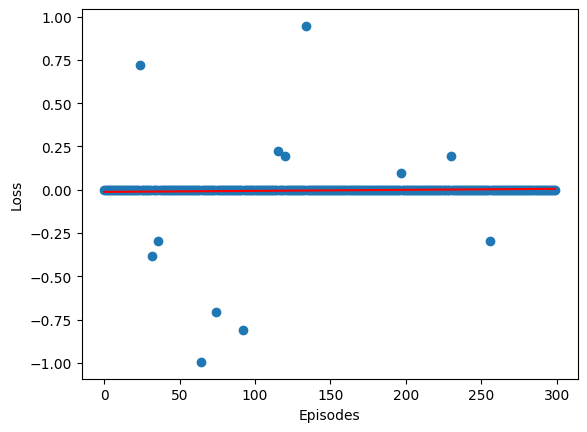

In [65]:
episodes = np.arange(len(losses))
plt.scatter(episodes, losses)
plt.plot(np.unique(episodes), np.poly1d(np.polyfit(episodes, losses, 1))(episodes), color = "red")
plt.xlabel("Episodes")
plt.ylabel("Loss")
plt.show()